***ShadowFox AI/ML Internship : Intermediate level***

# ***Store Sales and Profit Analysis (With Prediction)***

In [1]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 10.8 MB/s eta 0:00:00


In [38]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score
import joblib
import shap
from datetime import datetime
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Loading Dataset
store_data = pd.read_csv('/content/Superstore.csv',  encoding='ISO-8859-1')
store_data.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164
5,6,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
6,7,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00,1.9656
7,8,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152
8,9,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20,5.7825
9,10,CA-2014-115812,6/9/2014,6/14/2014,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00,34.4700


***Data Preprocessing and Analysis***

In [4]:
# Data Preprocessing and Analysis
def parse_dates(date):
    for fmt in ('%d/%m/%Y', '%m/%d/%Y', '%d-%m-%Y', '%m-%d-%Y', '%Y-%m-%d'):
        try:
            return pd.to_datetime(date, format=fmt)
        except ValueError:
            continue
    return pd.to_datetime(date, errors='coerce')

# Apply the function to parse and standardize the dates
store_data['Order Date'] = store_data['Order Date'].apply(parse_dates).dt.strftime('%Y-%m-%d')
store_data['Ship Date'] = store_data['Ship Date'].apply(parse_dates).dt.strftime('%Y-%m-%d')

store_data['Order Date'] = pd.to_datetime(store_data['Order Date'])
store_data['Ship Date'] = pd.to_datetime(store_data['Ship Date'])

# Create additional date-related features
store_data['Order Month'] = store_data['Order Date'].dt.to_period('M')
store_data['Order Year'] = store_data['Order Date'].dt.year


In [5]:
store_data.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Order Month,Order Year
0,1,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,2016-08,2016
1,2,CA-2016-152156,2016-08-11,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,2016-08,2016
2,3,CA-2016-138688,2016-12-06,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,2016-12,2016
3,4,US-2015-108966,2015-11-10,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,2015-11,2015
4,5,US-2015-108966,2015-11-10,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,2015-11,2015
5,6,CA-2014-115812,2014-09-06,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694,2014-09,2014
6,7,CA-2014-115812,2014-09-06,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,OFF-AR-10002833,Office Supplies,Art,Newell 322,7.2800,4,0.00,1.9656,2014-09,2014
7,8,CA-2014-115812,2014-09-06,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,907.1520,6,0.20,90.7152,2014-09,2014
8,9,CA-2014-115812,2014-09-06,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,18.5040,3,0.20,5.7825,2014-09,2014
9,10,CA-2014-115812,2014-09-06,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,114.9000,5,0.00,34.4700,2014-09,2014


In [6]:
# Checking for missing values
print("\nMissing values in each column:")
store_data.isnull().sum()


Missing values in each column:


,0
Row ID,0
Order ID,0
Order Date,0
Ship Date,0
Ship Mode,0
Customer ID,0
Customer Name,0
Segment,0
Country,0
City,0


In [7]:
# Checking for duplicates
print("\nNumber of duplicated rows:")
store_data.duplicated().sum()


Number of duplicated rows:


0

In [8]:
# Outlier Detection and Handling
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

store_data = remove_outliers(store_data, 'Sales')
store_data = remove_outliers(store_data, 'Profit')
store_data = remove_outliers(store_data, 'Discount')

In [9]:
# Convert categorical features to numerical
label_encoder = LabelEncoder()
categorical_columns = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode']

for col in categorical_columns:
    store_data[col] = label_encoder.fit_transform(store_data[col])


In [10]:
# Check for Multicollinearity
numerical_columns = ['Sales', 'Quantity', 'Discount']
X_temp = store_data[numerical_columns]
vif_data = pd.DataFrame()
vif_data["feature"] = X_temp.columns
vif_data["VIF"] = [variance_inflation_factor(X_temp.values, i) for i in range(len(X_temp.columns))]
print("VIF values for numerical features:\n", vif_data)

VIF values for numerical features:
     feature       VIF
0     Sales  1.617067
1  Quantity  1.805869
2  Discount  1.612098


***Exploratory Data Analysis***

In [11]:
store_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6779 entries, 0 to 9992
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         6779 non-null   int64         
 1   Order ID       6779 non-null   object        
 2   Order Date     6779 non-null   datetime64[ns]
 3   Ship Date      6779 non-null   datetime64[ns]
 4   Ship Mode      6779 non-null   int64         
 5   Customer ID    6779 non-null   object        
 6   Customer Name  6779 non-null   object        
 7   Segment        6779 non-null   int64         
 8   Country        6779 non-null   object        
 9   City           6779 non-null   object        
 10  State          6779 non-null   object        
 11  Postal Code    6779 non-null   int64         
 12  Region         6779 non-null   int64         
 13  Product ID     6779 non-null   object        
 14  Category       6779 non-null   int64         
 15  Sub-Category   6779 non-nu

In [12]:
store_data.describe()

,Row ID,Order Date,Ship Date,Ship Mode,Segment,Postal Code,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Order Year
count,6779.000000,6779,6779,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000,6779.000000
mean,4998.562030,2016-04-13 18:25:00.752323328,2016-04-22 06:31:16.736982016,2.240006,0.653931,55814.501991,1.665142,0.990559,7.111373,67.004453,3.453607,0.097199,11.327627,2015.729311
min,1.000000,2014-01-03 00:00:00,2014-01-04 00:00:00,0.000000,0.000000,1453.000000,0.000000,0.000000,0.000000,0.990000,1.000000,0.000000,-27.715800,2014.000000
25%,2514.500000,2015-05-03 00:00:00,2015-05-10 00:00:00,2.000000,0.000000,22304.000000,1.000000,1.000000,3.000000,14.940000,2.000000,0.000000,3.235200,2015.000000
50%,5022.000000,2016-06-06 00:00:00,2016-06-17 00:00:00,3.000000,0.000000,56560.000000,2.000000,1.000000,8.000000,34.790000,3.000000,0.000000,7.921200,2016.000000
75%,7464.500000,2017-04-09 00:00:00,2017-05-02 00:00:00,3.000000,1.000000,90036.000000,3.000000,1.000000,11.000000,82.600000,5.000000,0.200000,17.377200,2017.000000
max,9993.000000,2017-12-30 00:00:00,2018-05-01 00:00:00,3.000000,2.000000,99301.000000,3.000000,2.000000,15.000000,496.860000,14.000000,0.500000,50.584800,2017.000000
std,2878.409888,NaN,NaN,1.094294,0.761663,32815.156873,1.153073,0.575054,4.521659,84.303233,2.033511,0.105584,13.045945,1.123942


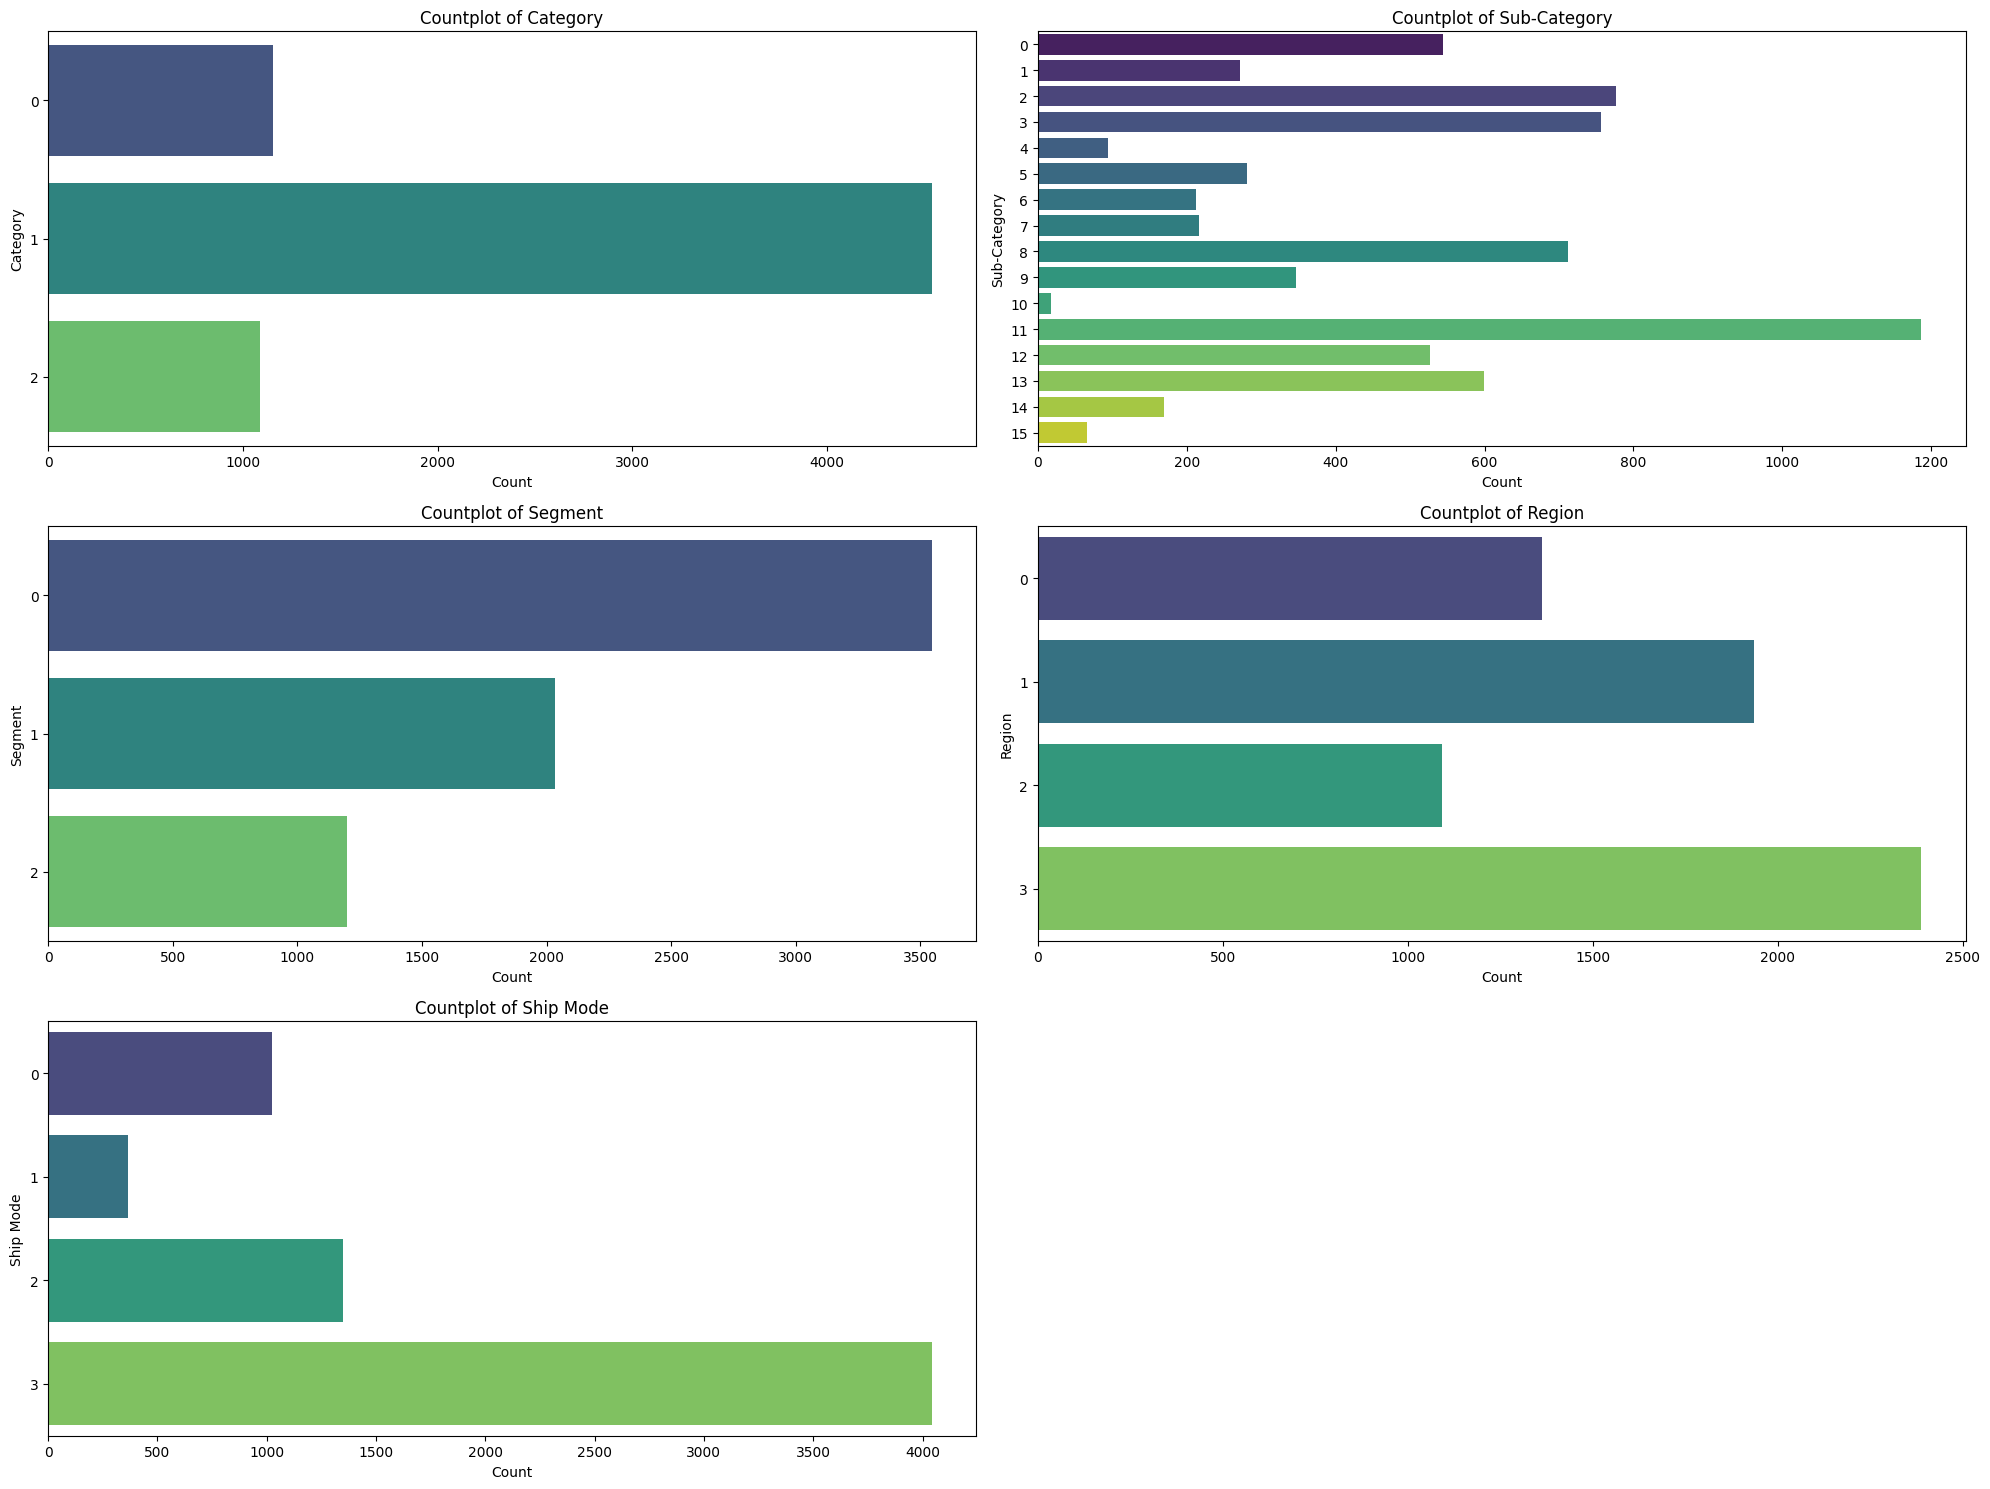

In [13]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(categorical_columns, 1):
    plt.subplot(3, 2, i)
    sns.countplot(y=feature, data=store_data, palette='viridis')
    plt.title(f'Countplot of {feature}')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.tight_layout()

plt.show()

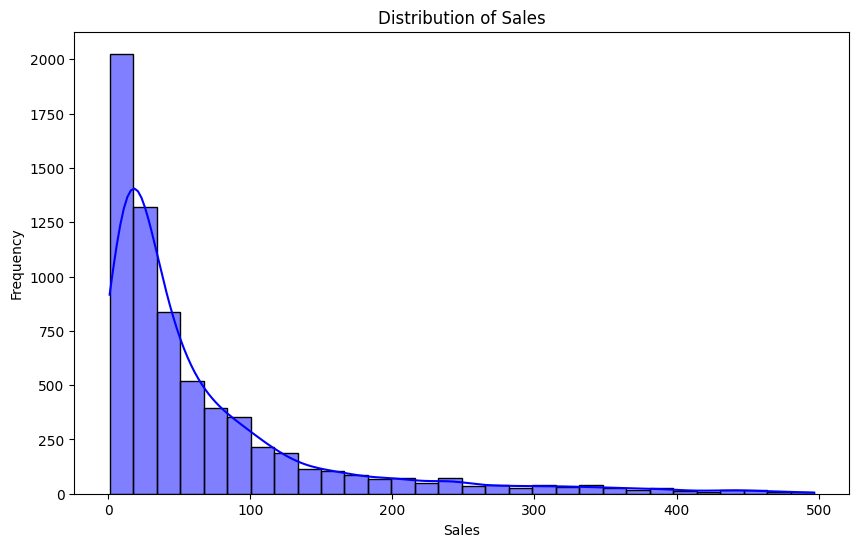

In [14]:
# Distribution of Sales
plt.figure(figsize=(10, 6))
sns.histplot(store_data['Sales'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

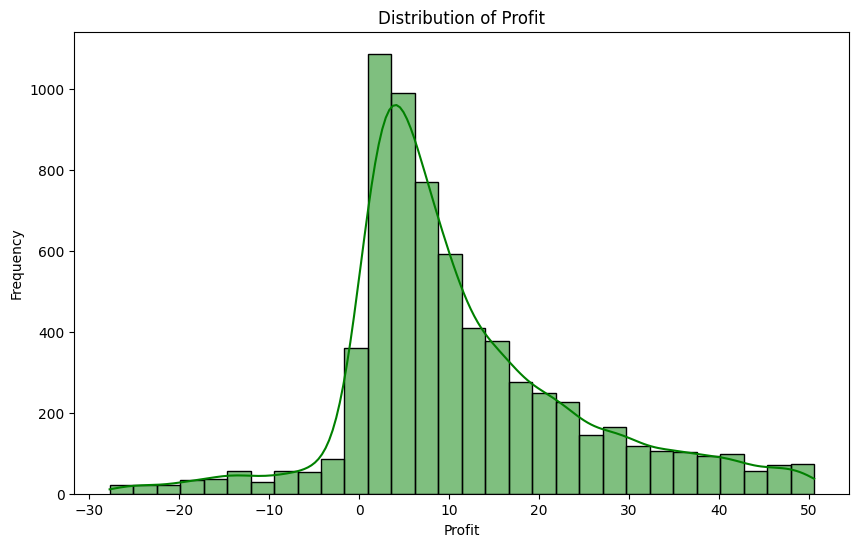

In [15]:
# Distribution of Profit
plt.figure(figsize=(10, 6))
sns.histplot(store_data['Profit'], bins=30, kde=True, color='green')
plt.title('Distribution of Profit')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()


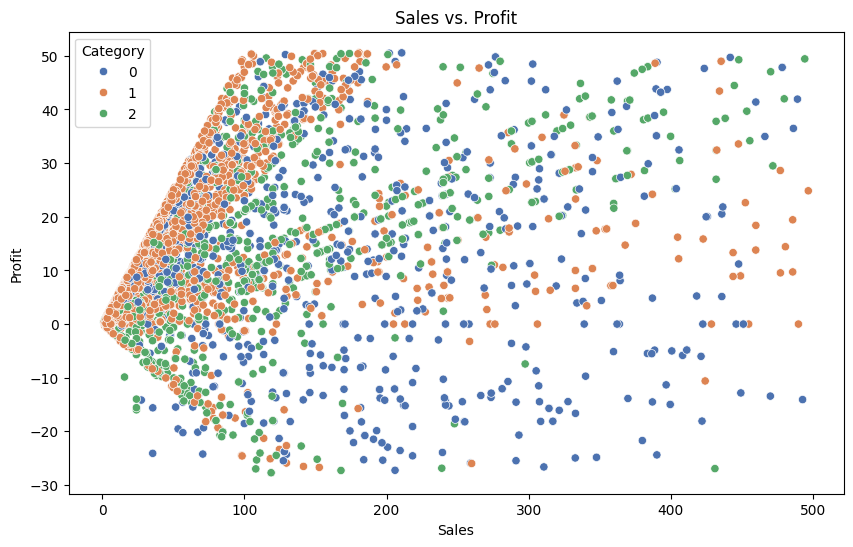

In [16]:
# Scatter Plot: Sales vs. Profit
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Sales', y='Profit', data=store_data, hue='Category', palette='deep')
plt.title('Sales vs. Profit')
plt.xlabel('Sales')
plt.ylabel('Profit')
plt.show()

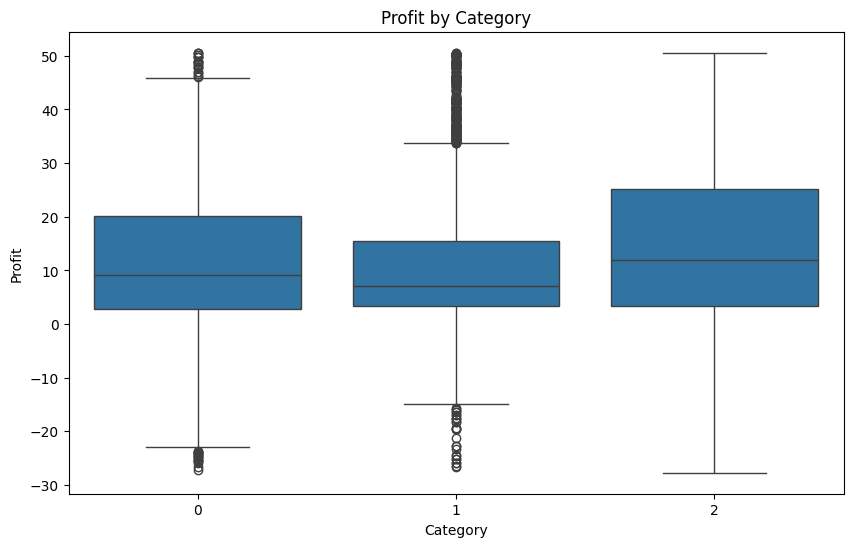

In [17]:
#Box Plot : Profit by Category
plt.figure(figsize=(10, 6))
sns.boxplot(x='Category', y='Profit', data=store_data)
plt.title('Profit by Category')
plt.xlabel('Category')
plt.ylabel('Profit')
plt.show()

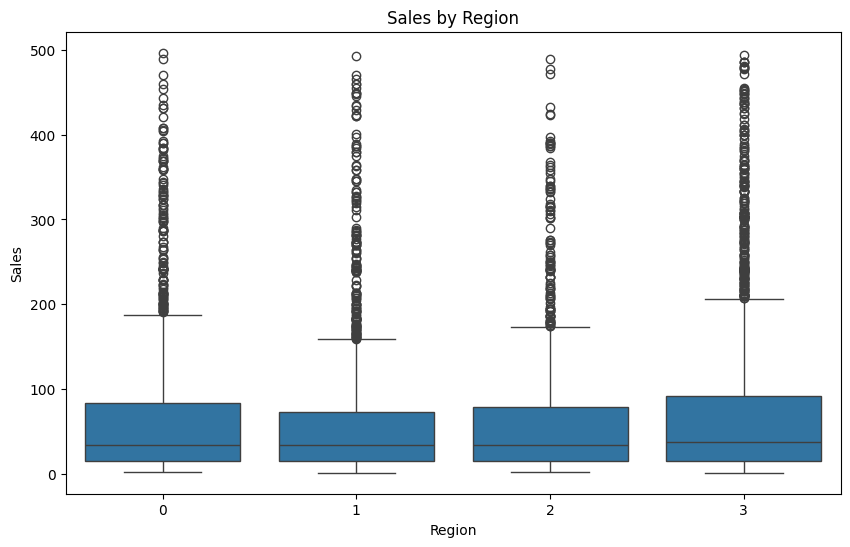

In [18]:
#Box plot : Sales by Region
plt.figure(figsize=(10, 6))
sns.boxplot(x='Region', y='Sales', data=store_data)
plt.title('Sales by Region')
plt.xlabel('Region')
plt.ylabel('Sales')
plt.show()

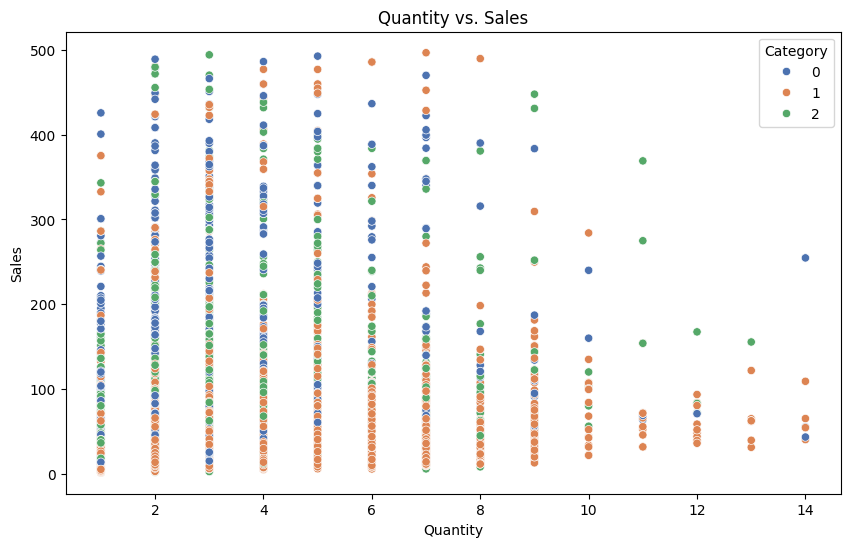

In [19]:
# Quantity vs. Sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Quantity', y='Sales', data=store_data, hue='Category', palette='deep')
plt.title('Quantity vs. Sales')
plt.xlabel('Quantity')
plt.ylabel('Sales')
plt.show()

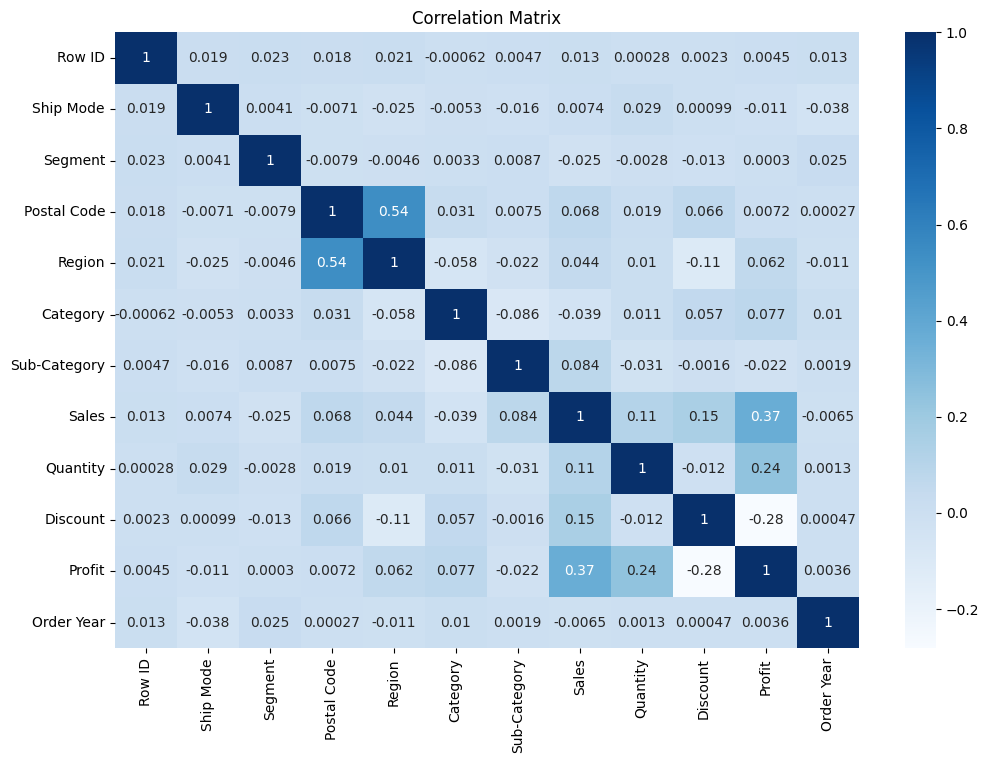

In [20]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
numerical_data = store_data.select_dtypes(include='number')
sns.heatmap(numerical_data.corr(), annot=True, cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

***Data Preparation For Prediction***

In [21]:
# Feature Selection and Scaling:
# Select relevant features for prediction
X = store_data[['Sales', 'Quantity', 'Discount', 'Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode']]
y = store_data['Profit']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [22]:
X_train.shape

(4745, 8)

In [23]:
X_test.shape

(2034, 8)

In [24]:
y_train.shape

(4745,)

In [25]:
y_test.shape

(2034,)

In [26]:
# Create a pipeline for scaling and modeling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [27]:
# Hyperparameter Tuning with GridSearchCV
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2],
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# Model Evaluation
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [28]:
# Model Evaluation
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

evaluation_metrics = {
    'Metric': ['Mean Absolute Error (MAE)', 'Mean Squared Error (MSE)', 'Root Mean Squared Error (RMSE)', 'R-squared (R2)'],
    'Value': [mae, mse, rmse, r2]
}

evaluation_df = pd.DataFrame(evaluation_metrics)
print("Evaluation Metrics:\n")
evaluation_df

Evaluation Metrics:



,Metric,Value
0,Mean Absolute Error (MAE),3.443075
1,Mean Squared Error (MSE),45.516516
2,Root Mean Squared Error (RMSE),6.746593
3,R-squared (R2),0.734703


In [29]:
# Cross-validation scores
cv_scores = cross_val_score(best_model, X, y, cv=5)
print("\nCross-validation scores:\n", cv_scores)
print("\nMean cross-validation score: ", np.mean(cv_scores))


Cross-validation scores:
 [0.69269565 0.72779915 0.73130016 0.74171185 0.72438024]

Mean cross-validation score:  0.7235774101820927


In [30]:
# Feature Importance
importances = best_model.named_steps['model'].feature_importances_
indices = np.argsort(importances)[::-1]

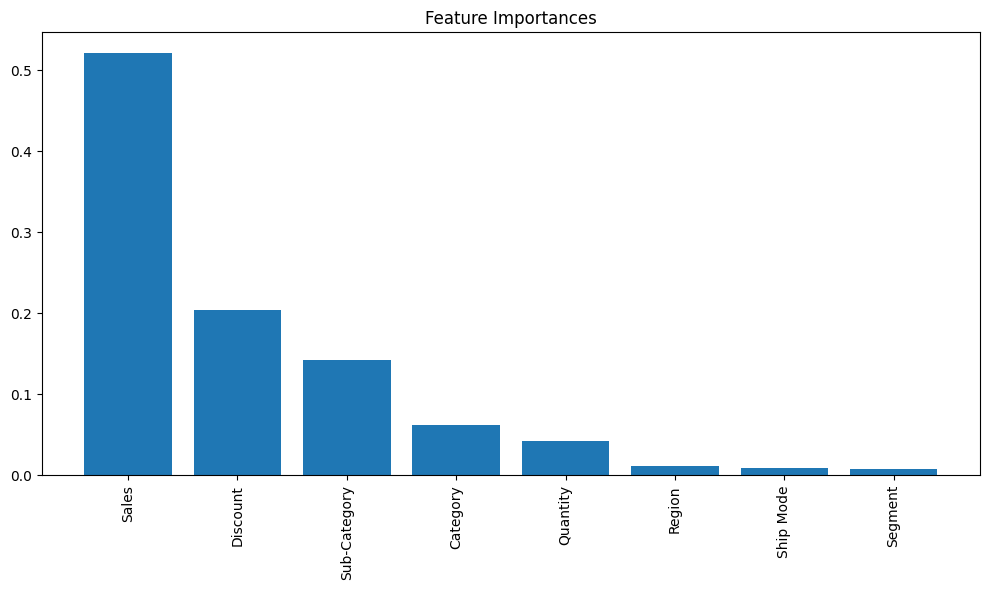

In [31]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

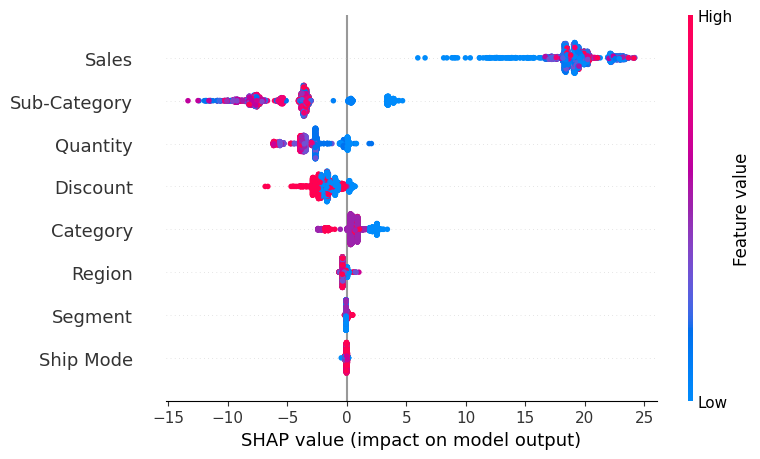

In [32]:
# SHAP Values for Model Interpretation
explainer = shap.TreeExplainer(best_model.named_steps['model'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)


In [33]:
comparison_df = pd.DataFrame({
    'Actual Profit': y_test,
    'Predicted Profit': y_pred
})

comparison_df.head(10)

,Actual Profit,Predicted Profit
6766,3.5460,2.705047
8401,12.8058,16.281582
8994,29.6920,32.118834
640,6.0288,7.160723
1557,9.9200,9.631656
4961,5.4801,3.317779
5033,7.4172,7.467485
3792,2.2044,1.947616
3724,2.2050,1.116262
3775,3.6288,3.524108


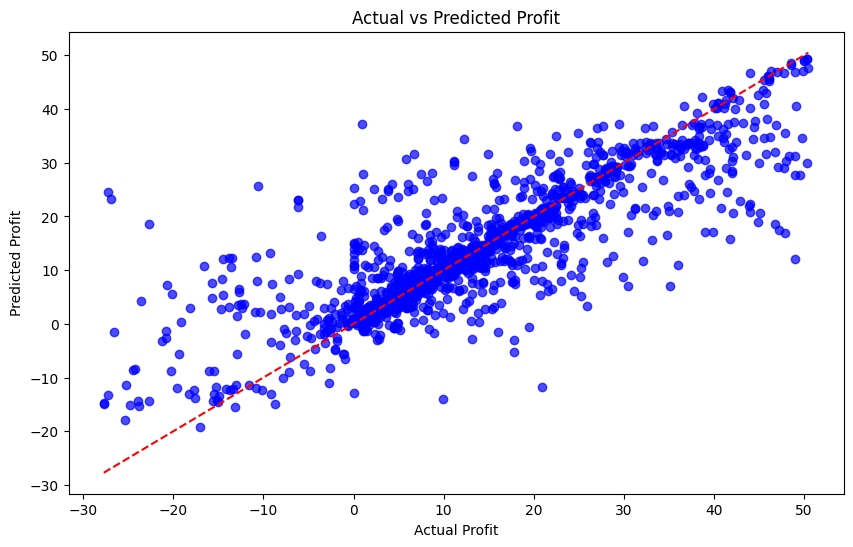

In [34]:
# Residual Analysis
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('Actual vs Predicted Profit')
plt.xlabel('Actual Profit')
plt.ylabel('Predicted Profit')
plt.show()

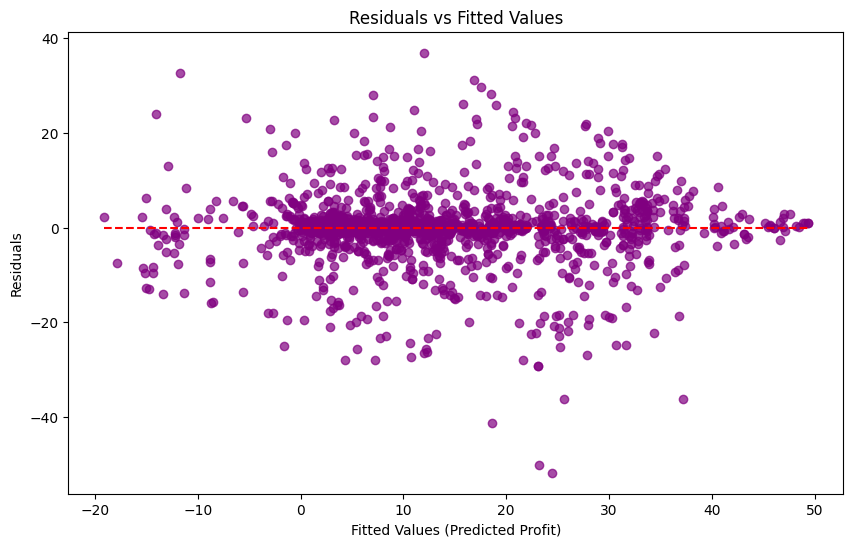

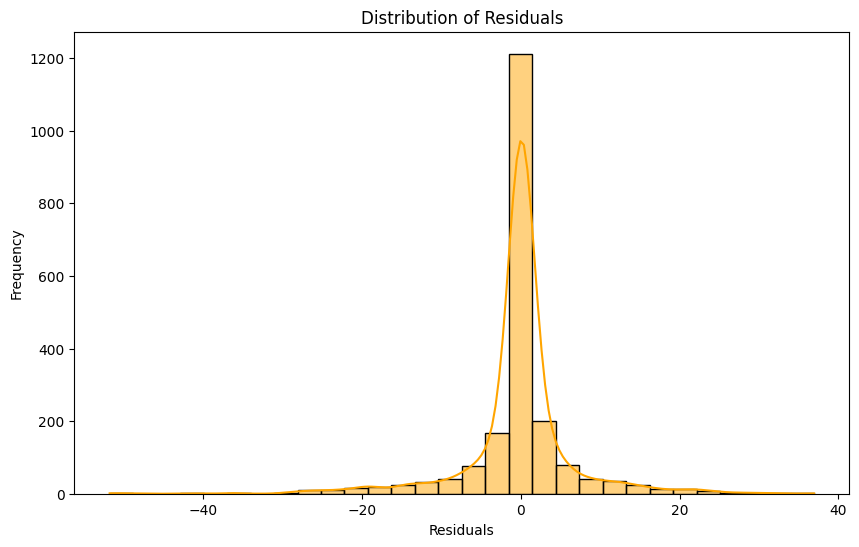

In [37]:
# Compute residuals
residuals = y_test - y_pred

# Residuals vs. Fitted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7, color='purple')
plt.hlines(y=0, xmin=min(y_pred), xmax=max(y_pred), linestyles='dashed', color='red')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values (Predicted Profit)')
plt.ylabel('Residuals')
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color='orange')
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [35]:
# Save the Model
joblib.dump(best_model, 'store_sales_profit_model.pkl')

['store_sales_profit_model.pkl']